In [5]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel("/content/drive/MyDrive/ExcelData/train.xlsx")
df1 = pd.read_excel("/content/drive/MyDrive/ExcelData/test.xlsx")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Load a sample dataset
hyperspectral_data = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values
feature_names = df.columns[:-1].values

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X = hyperspectral_data
y = encoded_labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the SVM hyperparameter optimization using Cuckoo Search
def cuckoo_search_svm(X_train, X_test, y_train, y_test, max_iters, population_size):
    # Initialize a population of random SVM hyperparameters
    population = []
    for _ in range(population_size):
        C = 10 ** np.random.uniform(-2, 2)  # Random C value in the range [0.01, 100]
        gamma = 10 ** np.random.uniform(-2, 2)  # Random gamma value in the range [0.01, 100]
        population.append((C, gamma))

    best_solution = None
    best_accuracy = 0.0

    for _ in range(max_iters):
        # Evaluate each solution in the population
        accuracies = []
        for C, gamma in population:
            clf = SVC(C=C, gamma=gamma, kernel='linear')
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

            if accuracy > best_accuracy:
                best_solution = (C, gamma)
                best_accuracy = accuracy

        # Sort the population by fitness (accuracy)
        population = [x for _, x in sorted(zip(accuracies, population), reverse=True)]

        # Levy flight step for cuckoos
        for i in range(1, population_size):
            step_size = np.random.normal(0, 1) * (1.0 / (np.sqrt(i) ** (1.0 / 3.0)))
            new_solution = (population[i][0] + step_size, population[i][1] + step_size)
            new_solution = (np.clip(new_solution[0], 0.01, 100), np.clip(new_solution[1], 0.01, 100))
            population[i] = new_solution

    return best_solution

# Hyperparameter optimization using Cuckoo Search
max_iters = 100
population_size = 10
best_C, best_gamma = cuckoo_search_svm(X_train, X_test, y_train, y_test, max_iters, population_size)

# Train the SVM with the best hyperparameters on the entire training dataset
start = time.perf_counter()
best_svm = SVC(C=best_C, gamma=best_gamma, kernel='linear')
best_svm.fit(X_train, y_train)
end = time.perf_counter()

# Evaluate the best SVM on the test dataset
y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Best C: {best_C}")
print(f"Best gamma: {best_gamma}")
print(f"Accuracy on test data: {accuracy}")
print('Time taken:', end-start, 'sec')

Best C: 3.490917666689484
Best gamma: 0.0769050414123522
Accuracy on test data: 0.9964028776978417
Time taken: 1.990560892999838 sec


Confusion Matrix:


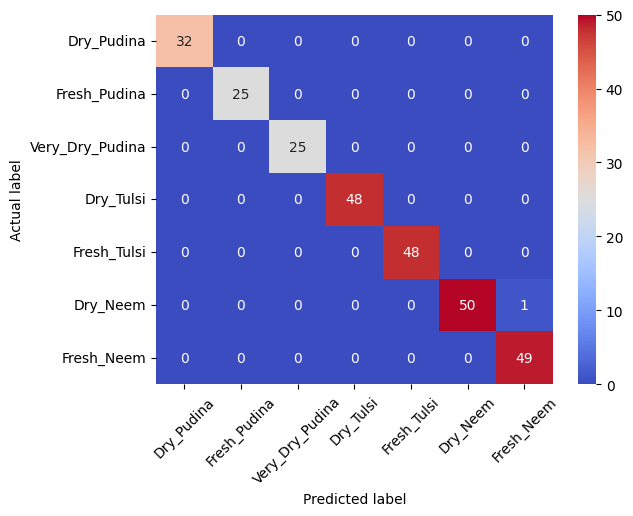

In [7]:
y_test = label_encoder.inverse_transform(y_test)
y_pred = label_encoder.inverse_transform(y_pred)
lb = ['Dry_Pudina', 'Fresh_Pudina', 'Very_Dry_Pudina', 'Dry_Tulsi', 'Fresh_Tulsi', 'Dry_Neem', 'Fresh_Neem']
confusion_mat = confusion_matrix(y_test,y_pred, labels=lb)
print("Confusion Matrix:")
sns.heatmap(
    confusion_mat,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=lb,
    yticklabels=lb,
)
plt.xticks(rotation=45)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()